# Single-label, multiclass classification

This notebook is for practising single-label multiclass classification with Keras library. This example is taken from Deep Learning with Python by Françoic Chollet (highly recommended).

In [17]:
from keras.datasets import reuters
from keras import models, layers
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.25)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Prepare dataset

In [ ]:
# keep only the top 10,000 most frequently occurring words
dimension = 10000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=dimension)

In [ ]:
def vectorise_sequences(sequences, dimension=10000):
    """One-hot encode lists into vectors of 0s and 1s"""
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# vectorise input data X
X_train = vectorise_sequences(train_data, dimension=dimension)
X_test = vectorise_sequences(test_data, dimension=dimension)

In [ ]:
# one-hot / categorical encoding to labels
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [ ]:
# validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

In [44]:
# check class imbalance (what do we do about it?)
np.unique(train_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 array([  55,  432,   74, 3159, 1949,   17,   48,   16,  139,  101,  124,
         390,   49,  172,   26,   20,  444,   39,   66,  549,  269,  100,
          15,   41,   62,   92,   24,   15,   48,   19,   45,   39,   32,
          11,   50,   10,   49,   19,   19,   24,   36,   30,   13,   21,
          12,   18]))

## 2. Building and train network

**Information bottleneck**  
In a sequential structure, each layer can only access information present in the output of the previous layer. If information is dropped by one layer, it will never be recovered by subsequent layers - potentially creating a information bottleneck. This can also be seen as compressing data into a lower dimensional representation which contains most of the necessary information but not all. Therefore for 46 different classes, we want to have more than 46 hidden units e.g. 64 units.

`softmax` activation means that the output is a probability distribution over the 46 classes. Each output is the probability of an image belonging to each class.

There are two options for the loss function:
- `categorical_crossentropy`: use when labels are one-hot encoded
- `sparse_categorical_crossentropy`: use when labels are integers

In [48]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(dimension,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [49]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

n_epochs = 20

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=n_epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val))

Train on 6017 samples, validate on 2965 samples
Epoch 1/20
6017/6017 [==============================] - 1s 160us/step - loss: 3.0043 - acc: 0.4351 - val_loss: 2.0949 - val_acc: 0.6368
Epoch 2/20
6017/6017 [==============================] - 1s 94us/step - loss: 1.6754 - acc: 0.6895 - val_loss: 1.4854 - val_acc: 0.6995
Epoch 3/20
6017/6017 [==============================] - 1s 94us/step - loss: 1.1769 - acc: 0.7565 - val_loss: 1.2547 - val_acc: 0.7322
Epoch 4/20
6017/6017 [==============================] - 1s 94us/step - loss: 0.9178 - acc: 0.8021 - val_loss: 1.1408 - val_acc: 0.7457
Epoch 5/20
6017/6017 [==============================] - 1s 95us/step - loss: 0.7449 - acc: 0.8386 - val_loss: 1.0795 - val_acc: 0.7592
Epoch 6/20
6017/6017 [==============================] - 1s 93us/step - loss: 0.6081 - acc: 0.8682 - val_loss: 1.0397 - val_acc: 0.7774
Epoch 7/20
6017/6017 [==============================] - 1s 94us/step - loss: 0.4946 - acc: 0.8981 - val_loss: 1.0097 - val_acc: 0.7892
Epoch 

## 3. Interpret model performance

In [50]:
def plot_loss_acc(history, epochs):
    history_dict = history.history

    # loss
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    # accurancy
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(epochs, loss_values, 'bo', label='training loss')
    ax[0].plot(epochs, val_loss_values, 'b', label='validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, acc_values, 'bo', label='training accuracy')
    ax[1].plot(epochs, val_acc_values, 'b', label='validation accuracy')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

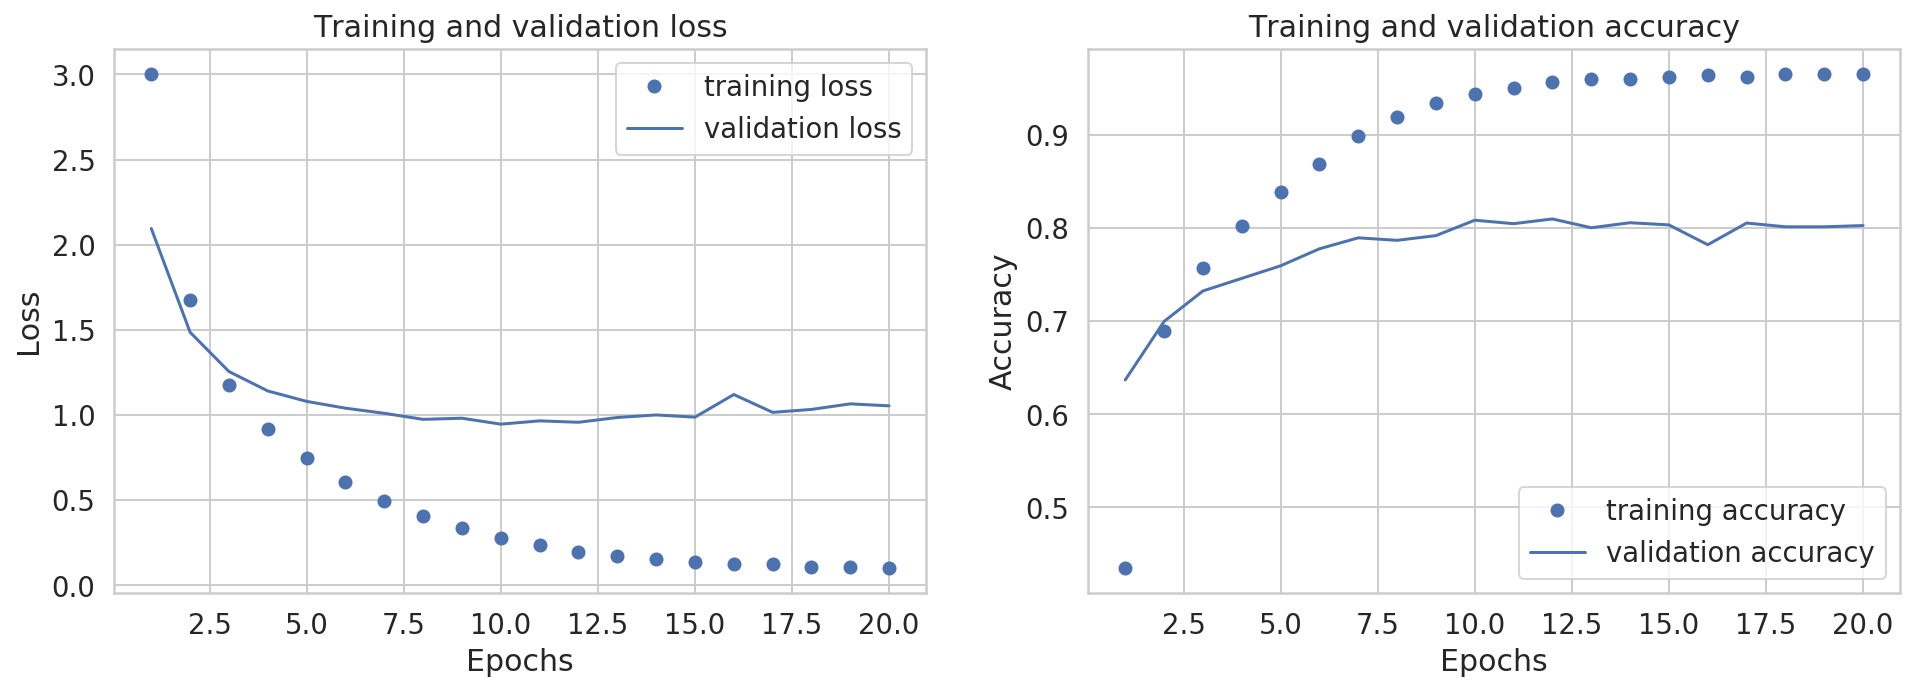

In [51]:
epochs = range(1, n_epochs + 1)
plot_loss_acc(history, epochs)

The model starts to overfit after epoch 9, so retrain model with n_epochs=9.

Train on 6017 samples, validate on 2965 samples
Epoch 1/9
6017/6017 [==============================] - 1s 162us/step - loss: 2.8265 - acc: 0.4078 - val_loss: 2.0058 - val_acc: 0.6061
Epoch 2/9
6017/6017 [==============================] - 1s 93us/step - loss: 1.6532 - acc: 0.6623 - val_loss: 1.5023 - val_acc: 0.6786
Epoch 3/9
6017/6017 [==============================] - 1s 100us/step - loss: 1.2228 - acc: 0.7364 - val_loss: 1.2965 - val_acc: 0.7197
Epoch 4/9
6017/6017 [==============================] - 1s 104us/step - loss: 0.9691 - acc: 0.7941 - val_loss: 1.1663 - val_acc: 0.7386
Epoch 5/9
6017/6017 [==============================] - 1s 100us/step - loss: 0.7822 - acc: 0.8353 - val_loss: 1.0968 - val_acc: 0.7599
Epoch 6/9
6017/6017 [==============================] - 1s 105us/step - loss: 0.6328 - acc: 0.8664 - val_loss: 1.0413 - val_acc: 0.7730
Epoch 7/9
6017/6017 [==============================] - 1s 104us/step - loss: 0.5089 - acc: 0.8991 - val_loss: 0.9990 - val_acc: 0.7872
Epoch 8/

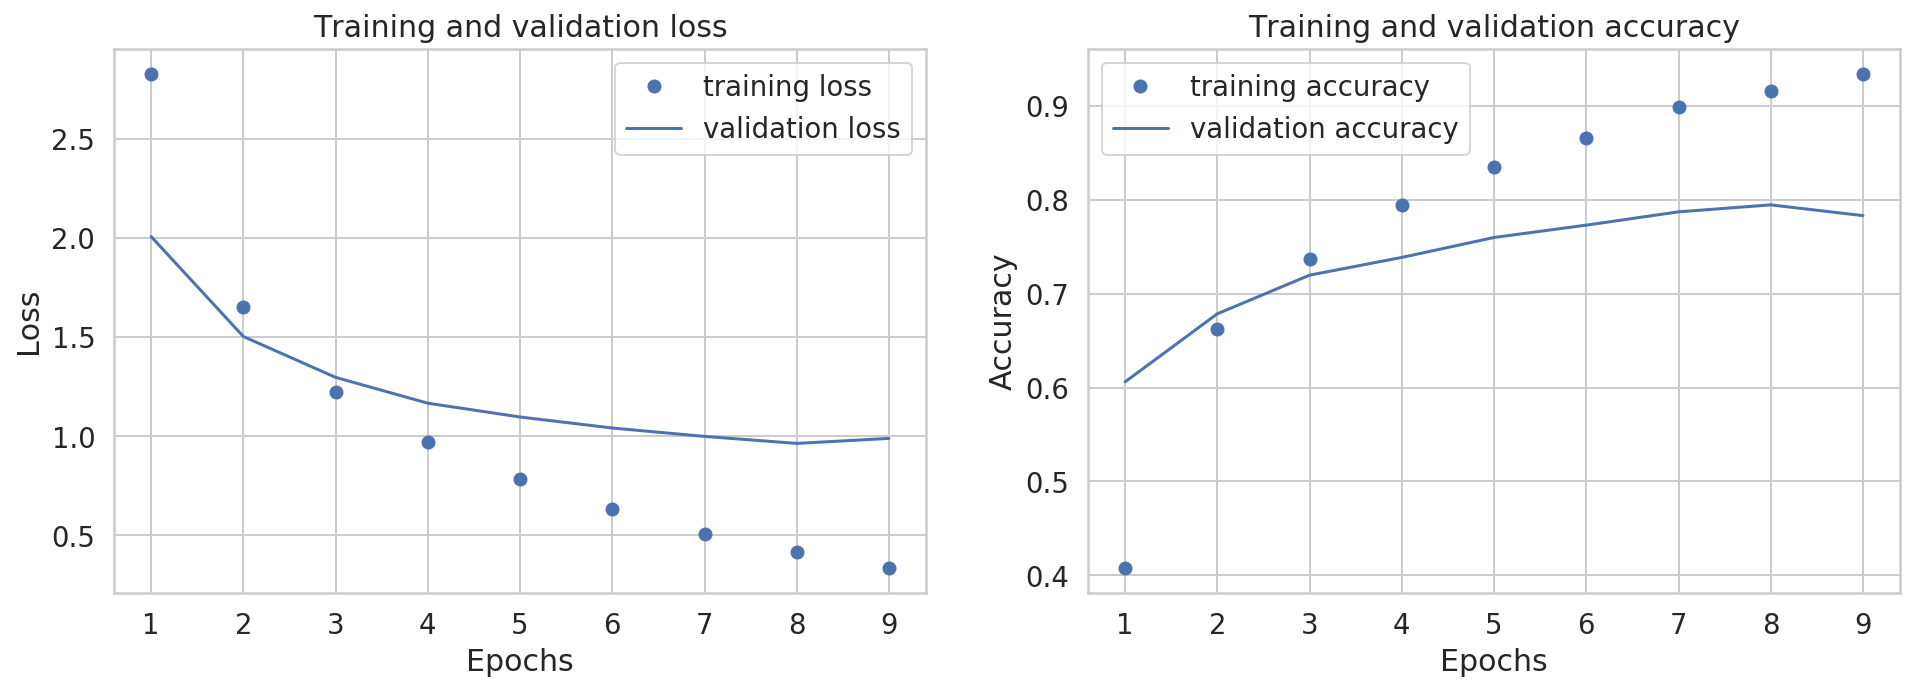

In [56]:
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(dimension,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

n_epochs = 9

history2 = model2.fit(x=X_train,
                      y=y_train,
                      epochs=n_epochs,
                      batch_size=512,
                      validation_data=(X_val, y_val))

epochs = range(1, n_epochs + 1)
plot_loss_acc(history2, epochs)

## 4. Make prediction

In [57]:
predictions = model2.predict(X_test)

In [58]:
# verify if each prediction sums to 1
predictions[0].sum()

1.0

In [65]:
# output class membership
np.argmax(predictions, axis=1)

array([ 3, 10,  1, ...,  3,  3,  1])